In [ ]:
# ---- Standard library ----
import os
import glob
import itertools
import re

# ---- Numerical & data ----
import numpy as np
import pandas as pd

# ---- Scientific computing ----
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# ---- Bioinformatics ----
from Bio import PDB  # Biopython for simple PDB parsing

# ---- Graphs ----
import networkx as nx

# ---- Machine Learning ----
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ---- Visualization ----
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# ==== CELL: Plotting Functions ====
def plot_predictions(y_test, y_pred, title="Actual vs Predicted Fitness Values (Test Set)"):
    """
    Basic scatter plot: actual vs predicted fitness values with y=x line.
    """
    y_true = np.asarray(y_test)
    y_pred = np.asarray(y_pred)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k', label='Predicted vs Actual')

    if y_true.size > 0 and y_pred.size > 0:
        min_val = float(min(np.min(y_true), np.min(y_pred)))
        max_val = float(max(np.max(y_true), np.max(y_pred)))
    else:
        min_val, max_val = 0.0, 1.0

    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', lw=2, label='Perfect Prediction Line')
    plt.xlabel("Actual Fitness")
    plt.ylabel("Predicted Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions1(y_true, y_pred):
    """
    Advanced scatter plot with:
      - color-coded error |y_pred - y_true|
      - y = x line
      - shaded ±1 and ±0.5 regions around y = x
      - RMSD and Pearson R on the plot
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    errors = np.abs(y_pred - y_true)
    colors = errors

    plt.figure(figsize=(7, 7))

    # Scatter with color gradient based on error
    scatter = plt.scatter(y_true, y_pred, c=colors, cmap='coolwarm',
                          alpha=0.7, edgecolors='k')
    plt.colorbar(scatter, label="|Prediction Error| (|y_pred - y_true|)")

    # Identity line
    plt.plot([-2, 9], [-2, 9], 'k-', lw=2, label="y = x")

    x_fill = np.array([-2, 9])

    # ±1 region
    plt.fill_between(x_fill, x_fill - 1, x_fill + 1,
                     color='gray', alpha=0.1, label='±1 Region')
    # ±0.5 region
    plt.fill_between(x_fill, x_fill - 0.5, x_fill + 0.5,
                     color='gray', alpha=0.3, label='±0.5 Region')

    # Metrics
    try:
        rmsd = np.sqrt(mean_squared_error(y_true, y_pred))
    except ValueError:
        rmsd = np.nan
    try:
        pearson_corr, _ = pearsonr(y_true, y_pred)
    except Exception:
        pearson_corr = np.nan

    textstr = f'RMSD: {rmsd:.2f}\nPearson: {pearson_corr:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    plt.text(0.05, 0.95, textstr,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=props)

    plt.axis("square")
    plt.xlim(-2, 9)
    plt.ylim(-2, 9)
    plt.xlabel("Actual Fitness")
    plt.ylabel("Predicted Fitness")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('predicted_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_bootstrapped_metric_bars(metric_means, metric_cis, metric_names):
    """
    Bar chart for bootstrapped performance metrics with 95% CIs.

    Args:
        metric_means (list of float): Mean value for each metric.
        metric_cis (list of (lower, upper)): 95% CI bounds for each metric.
        metric_names (list of str): Names for each metric.
    """
    num_metrics = len(metric_names)
    y_err = np.zeros((2, num_metrics))
    for i in range(num_metrics):
        lower_ci, upper_ci = metric_cis[i]
        mean_val = metric_means[i]
        y_err[0, i] = mean_val - lower_ci    # below mean
        y_err[1, i] = upper_ci - mean_val    # above mean

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metric_names, metric_means, yerr=y_err,
                   capsize=5, color='skyblue', alpha=0.7)
    plt.ylabel("Metric Value")
    plt.title("Bootstrapped Performance Metrics (95% CIs)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Label each bar with its mean value
    for i, (bar, mean_val) in enumerate(zip(bars, metric_means)):
        yval = bar.get_height()
        text_y_pos = yval + (y_err[1, i] * 0.1)
        plt.text(bar.get_x() + bar.get_width() / 2.0,
                 text_y_pos, f'{mean_val:.3f}',
                 va='bottom', ha='center')

    plt.tight_layout()
    plt.savefig('bootstrapped_metrics_bars.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_predictions_with_confidence(
    y_true,
    mean_preds,
    pred_ci_lower,
    pred_ci_upper,
    title_suffix="Test Set"
):
    """
    Plot actual vs mean predicted values with 95% CI error bars for each point.

    Args:
        y_true (array-like): True target values.
        mean_preds (array-like): Mean predicted values from bootstrap.
        pred_ci_lower (array-like): Lower CI bound for each prediction.
        pred_ci_upper (array-like): Upper CI bound for each prediction.
    """
    y_true = np.asarray(y_true)
    mean_preds = np.asarray(mean_preds)
    pred_ci_lower = np.asarray(pred_ci_lower)
    pred_ci_upper = np.asarray(pred_ci_upper)

    y_err = np.vstack([
        mean_preds - pred_ci_lower,
        pred_ci_upper - mean_preds
    ])

    plt.figure(figsize=(10, 8))
    plt.errorbar(
        y_true,
        mean_preds,
        yerr=y_err,
        fmt='o',
        color='blue',
        ecolor='lightgray',
        elinewidth=1,
        capsize=3,
        alpha=0.6,
        markersize=5,
        label='Mean prediction with 95% CI'
    )

    if y_true.size > 0:
        min_val = float(min(np.min(y_true), np.min(pred_ci_lower)))
        max_val = float(max(np.max(y_true), np.max(pred_ci_upper)))
    else:
        min_val, max_val = 0.0, 1.0

    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', lw=2, label='y = x')

    plt.xlabel("Actual Fitness")
    plt.ylabel("Mean Predicted Fitness (Bootstrap)")
    plt.title(f"Actual vs Mean Predicted Fitness with 95% CIs ({title_suffix})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    safe_suffix = re.sub(r'[^a-zA-Z0-9_]', '_', title_suffix.lower().replace(' ', '_'))
    plt.savefig(f'predictions_with_confidence_{safe_suffix}.png',
                dpi=300, bbox_inches='tight')
    plt.show()


def plot_correlation_matrix(df, title="Feature Correlation Matrix", annot_threshold=40):
    """
    Heatmap of the correlation matrix for a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        title (str): Title of plot.
        annot_threshold (int): If #features > threshold, turn off annotations.
    """
    if df is None or df.empty or df.shape[1] < 2:
        print("[WARN] Correlation matrix cannot be plotted: DataFrame invalid or < 2 columns.")
        return

    corr_matrix = df.corr(numeric_only=True)
    num_features = len(corr_matrix.columns)

    print(f"[INFO] Computing correlation matrix for DataFrame with shape: {df.shape}")

    fig_width = max(12, num_features * 0.4)
    fig_height = max(10, num_features * 0.35)

    annot_flag = num_features <= annot_threshold
    if not annot_flag:
        print(f"[INFO] Number of features ({num_features}) > {annot_threshold}. "
              f"Turning off annotations for clarity.")

    if num_features > 70:
        annot_font_size = 4
        tick_font_size = 5
    elif num_features > 50:
        annot_font_size = 6
        tick_font_size = 6
    else:
        annot_font_size = 8
        tick_font_size = 8

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        corr_matrix,
        annot=annot_flag,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=.5,
        vmin=-1,
        vmax=1,
        annot_kws={"size": annot_font_size}
    )
    plt.title(title, fontsize=14)
    plt.xticks(rotation=60, ha="right", fontsize=tick_font_size)
    plt.yticks(rotation=0, fontsize=tick_font_size)
    plt.tight_layout(pad=1.5)

    try:
        safe_title = re.sub(r'[^a-zA-Z0-9_]', '_', title.lower().replace(" ", "_"))
        filename = f'{safe_title}_correlation_matrix.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"[INFO] Correlation matrix saved as {filename}")
    except Exception as e:
        print(f"[WARN] Could not save correlation matrix plot: {e}")

    plt.show()

def plot_predictions1_with_error_bars(y_true, y_pred, pred_ci_lower, pred_ci_upper):
    """
    Advanced scatter plot with:
      - error bars (95% CI) on predictions
      - color-coded error |y_pred - y_true|
      - y = x line and shaded ±1 / ±0.5 regions
      - RMSD and Pearson R on the plot.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    pred_ci_lower = np.asarray(pred_ci_lower)
    pred_ci_upper = np.asarray(pred_ci_upper)

    errors = np.abs(y_pred - y_true)
    colors = errors

    plt.figure(figsize=(8, 8))

    y_err = np.vstack([
        y_pred - pred_ci_lower,
        pred_ci_upper - y_pred
    ])

    # Errorbar layer
    plt.errorbar(
        y_true, y_pred, yerr=y_err,
        fmt='o',
        color='blue',
        ecolor='lightgray',
        elinewidth=1,
        capsize=3,
        alpha=0.6,
        markersize=5,
        zorder=2
    )

    # Scatter layer with colormap
    scatter_points = plt.scatter(
        y_true, y_pred,
        c=colors,
        cmap='coolwarm',
        alpha=0.7,
        edgecolors='k',
        zorder=3
    )
    plt.colorbar(scatter_points, label="|Prediction Error| (|y_pred - y_true|)")

    # Identity line and shaded regions
    x_fill = np.array([-2, 9])
    plt.plot(x_fill, x_fill, 'k-', lw=2, label="y = x", zorder=4)
    plt.fill_between(x_fill, x_fill - 1, x_fill + 1,
                     color='gray', alpha=0.1,
                     label='±1 Region', zorder=1)
    plt.fill_between(x_fill, x_fill - 0.5, x_fill + 0.5,
                     color='gray', alpha=0.3,
                     label='±0.5 Region', zorder=1)

    # Metrics
    try:
        rmsd = np.sqrt(mean_squared_error(y_true, y_pred))
    except ValueError:
        rmsd = np.nan
    try:
        pearson_corr, _ = pearsonr(y_true, y_pred)
    except Exception:
        pearson_corr = np.nan

    textstr = f'RMSD: {rmsd:.2f}\nPearson: {pearson_corr:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    plt.text(0.05, 0.95, textstr,
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=props)

    plt.axis("square")
    plt.xlim(-2, 9)
    plt.ylim(-2, 9)
    plt.xlabel("Actual Fitness")
    plt.ylabel("Predicted Fitness")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('predicted_fixed_with_errors.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def parse_hbond_file(hbond_filepath):
    """Extract HBond counts from the file."""
    hbond_counts = []
    with open(hbond_filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            hcount = float(parts[1])
            hbond_counts.append(hcount)
    return hbond_counts

def parse_pdb_file(pdb_filepath):
    """Extracts alpha carbon (CA) coordinates from the file."""
    ca_coordinates = []
    with open(pdb_filepath, 'r') as f:
        for line in f:
            if line.startswith("ATOM") and " CA " in line:
                residue_index = int(line[22:26].strip())
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                ca_coordinates.append((residue_index, x, y, z))
    return ca_coordinates

def compute_graph_features(ca_coordinates):
    """Compute graph-based features (TotalLength, AvgDegree, AvgClustering)."""
    if not ca_coordinates:
        return 0, 0, 0  # If no coordinates, return 0s

    G = nx.Graph()
    coords = np.array([(x, y, z) for _, x, y, z in ca_coordinates])
    residue_nums = [res_idx for res_idx, _, _, _ in ca_coordinates]

    # Build edges if distance < 6.7 Å
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist < 6.7:
                G.add_edge(residue_nums[i], residue_nums[j], weight=dist)

    if G.number_of_nodes() == 0:
        return 0, 0, 0

    total_length = sum(nx.get_edge_attributes(G, 'weight').values())
    avg_degree = sum(dict(G.degree()).values()) / len(G.nodes)
    avg_clustering = nx.average_clustering(G, weight='weight')
    return total_length, avg_degree, avg_clustering

# ===== Spherical coordinate utilities =====
def _cartesian_to_spherical_batch(rel_coords):
    """
    Convert an array of Cartesian coordinates (N x 3) to spherical:
      r, theta, phi
    Conventions:
      r     : radial distance
      theta : polar angle from +z (0..pi)
      phi   : azimuth angle from +x towards +y (-pi..pi)
    """
    if rel_coords.size == 0:
        return (
            np.array([], dtype=float),
            np.array([], dtype=float),
            np.array([], dtype=float),
        )

    x = rel_coords[:, 0]
    y = rel_coords[:, 1]
    z = rel_coords[:, 2]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.zeros_like(r)
    nonzero = r > 0
    theta[nonzero] = np.arccos(z[nonzero] / r[nonzero])
    phi = np.arctan2(y, x)
    return r, theta, phi

def compute_spherical_features(ca_coordinates, origin=None, prefix="Sph"):
    """
    Compute summary spherical-coordinate features for a set of CA coordinates.

    Args:
        ca_coordinates (list of (res_idx, x, y, z)):
            Coordinates for alpha carbons.
        origin (array-like or None):
            If None, use the mean coordinate as origin.
            Otherwise, a 3-element iterable (x0, y0, z0) for the origin.
        prefix (str):
            Prefix for feature names (e.g., 'SphCenter', 'SphMut').

    Returns:
        dict: {
          f"{prefix}_R_Mean", f"{prefix}_R_Std", f"{prefix}_R_Min", f"{prefix}_R_Max",
          f"{prefix}_Theta_Mean", f"{prefix}_Theta_Std",
          f"{prefix}_Phi_Mean",   f"{prefix}_Phi_Std"
        }
        or {} if no coordinates.
    """
    if not ca_coordinates:
        return {}

    coords = np.array([(x, y, z) for _, x, y, z in ca_coordinates], dtype=float)

    if origin is None:
        origin_vec = coords.mean(axis=0)
    else:
        origin_vec = np.asarray(origin, dtype=float)

    rel_coords = coords - origin_vec
    r_vals, theta_vals, phi_vals = _cartesian_to_spherical_batch(rel_coords)

    if r_vals.size == 0:
        return {}
    
    features = {
        f"{prefix}_R_Mean": float(r_vals.mean()),
        f"{prefix}_R_Std":  float(r_vals.std(ddof=0)),
        f"{prefix}_R_Min":  float(r_vals.min()),
        f"{prefix}_R_Max":  float(r_vals.max()),
        f"{prefix}_Theta_Mean": float(theta_vals.mean()),
        f"{prefix}_Theta_Std":  float(theta_vals.std(ddof=0)),
        f"{prefix}_Phi_Mean":   float(phi_vals.mean()),
        f"{prefix}_Phi_Std":    float(phi_vals.std(ddof=0)),
    }
    return features

In [ ]:
def bootstrap_xgboost(
    X_train,
    y_train,
    X_test,
    y_test,
    n_bootstrap=500,
    base_random_state=42,
    xgb_params=None,
):
    """
    Bootstrap XGBRegressor to obtain:
      - CIs for performance metrics (MSE, R², Pearson r)
      - CIs for each individual test prediction.
    """
    rng = np.random.default_rng(base_random_state)

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    if xgb_params is None:
        xgb_params = dict(
            n_estimators=600,
            learning_rate=0.03,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective="reg:squarederror",
            tree_method="hist",
            n_jobs=-1,
        )

    all_preds = np.zeros((n_bootstrap, n_test), dtype=float)

    mse_vals = np.zeros(n_bootstrap, dtype=float)
    r2_vals = np.zeros(n_bootstrap, dtype=float)
    pearson_vals = np.zeros(n_bootstrap, dtype=float)

    for b in range(n_bootstrap):
        sample_idx = rng.integers(0, n_train, size=n_train)
        X_boot = X_train.iloc[sample_idx]
        y_boot = y_train.iloc[sample_idx]

        model_b = XGBRegressor(
            random_state=base_random_state + b,
            **xgb_params
        )
        model_b.fit(X_boot, y_boot)

        preds = model_b.predict(X_test)
        all_preds[b, :] = preds

        mse_vals[b] = mean_squared_error(y_test, preds)
        r2_vals[b] = r2_score(y_test, preds)

        try:
            pearson_vals[b] = pearsonr(y_test, preds)[0]
        except Exception:
            pearson_vals[b] = np.nan

    metric_names = ["MSE", "R²", "Pearson r"]
    metric_arrays = [mse_vals, r2_vals, pearson_vals]

    metric_means = [np.nanmean(arr) for arr in metric_arrays]
    metric_cis = []
    for arr in metric_arrays:
        arr_clean = arr[~np.isnan(arr)]
        lower = float(np.percentile(arr_clean, 2.5))
        upper = float(np.percentile(arr_clean, 97.5))
        metric_cis.append((lower, upper))

    mean_preds = np.mean(all_preds, axis=0)
    pred_ci_lower = np.percentile(all_preds, 2.5, axis=0)
    pred_ci_upper = np.percentile(all_preds, 97.5, axis=0)

    results = {
        "metric_names": metric_names,
        "metric_means": metric_means,
        "metric_cis": metric_cis,
        "mean_preds": mean_preds,
        "pred_ci_lower": pred_ci_lower,
        "pred_ci_upper": pred_ci_upper,
        "all_preds": all_preds,
        "mse_vals": mse_vals,
        "r2_vals": r2_vals,
        "pearson_vals": pearson_vals,
    }
    return results

In [ ]:
def build_dataset(base_dir):
    import os
    import glob
    import numpy as np
    import pandas as pd

    mutation_folders = [
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d != "mutations_without_fitness"
    ]

    all_hbonds = []
    data_records = []

    # ✅ Toggle which GB1 features to include
    gb1_feature_toggle = {
        "sidechain and resid 27 sidechain and resid 254": True,
        "sidechain and resid 28 sidechain and resid 380": True,
        "sidechain and resid 28 sidechain and resid 382": True,
        "sidechain and resid 43 sidechain and resid 434": True,
        "sidechain and resid 27 backbone and resid 254": True,
        "sidechain and resid 27 backbone and resid 253": False,
        "sidechain and resid 40 sidechain and resid 433": False,
        "sidechain and resid 40 backbone and resid 434": False,
        "sidechain and resid 35 sidechain and resid 434": True,
        "Total": True
    }

    gb1_named_features = list(gb1_feature_toggle.keys())
    selected_gb1_features = [f for f in gb1_named_features if gb1_feature_toggle[f]]
    selected_gb1_indices = [
        i for i, f in enumerate(gb1_named_features) if gb1_feature_toggle[f]
    ]

    for folder_name in mutation_folders:
        folder_path = os.path.join(base_dir, folder_name)

        # File patterns
        hbond_pattern = os.path.join(folder_path, "*_hbonds.dat")
        hbond_files = glob.glob(hbond_pattern)

        bound_sasa_files = glob.glob(os.path.join(folder_path, "*_full_sasa_whole_prot.dat"))
        unbound_sasa_files = glob.glob(os.path.join(folder_path, "*_mutated_autopsf_wb_ionized_lf_sasa_whole_prot.dat"))
        pdb_files = glob.glob(os.path.join(folder_path, "*_mutated_autopsf_wb_ionized_lf.pdb"))
        fitness_files = glob.glob(os.path.join(folder_path, "otw_binding.dat"))  # Or *_fitness.dat

        wildtype_res_path = os.path.join(folder_path, "wild_type_aminoacid.dat")
        gb1_hbond_path = os.path.join(folder_path, "321321")  # hbonds_between_gb1.dat

        if not (len(bound_sasa_files) == 1 and
                len(unbound_sasa_files) == 1 and
                len(pdb_files) == 1 and
                len(fitness_files) == 1):
            print(f"[WARN] Missing or extra essential files in {folder_name}, skipping.")
            continue

        try:
            res_index_str = folder_name.split("_")[0].replace("res", "")
            mutated_res = folder_name.split("_")[1]
            res_index = int(res_index_str)

            if len(hbond_files) == 1:
                hbond_counts = parse_hbond_file(hbond_files[0])
            else:
                hbond_counts = []

            sasa_bound_val = float(open(bound_sasa_files[0]).read().strip())
            sasa_unbound_val = float(open(unbound_sasa_files[0]).read().strip())
            pdb_file = pdb_files[0]
            ca_coordinates = parse_pdb_file(pdb_file)
            fitness_val = float(open(fitness_files[0]).read().strip())

            # --- Graph-based features ---
            total_length, avg_degree, avg_clustering = compute_graph_features(ca_coordinates)

            wildtype_res = open(wildtype_res_path).read().strip() if os.path.exists(wildtype_res_path) else "UNK"

            gb1_hbond_values = []
            if os.path.exists(gb1_hbond_path):
                with open(gb1_hbond_path, "r") as f:
                    line = f.readline().strip()
                    gb1_hbond_values = [float(x) for x in line.split(",") if x.strip()]

            # --- Spherical features ---

            # 1) Origin at center-of-mass of all CA atoms
            sph_center_feats = compute_spherical_features(
                ca_coordinates,
                origin=None,
                prefix="SphCenter"
            )

            # 2) Origin at the mutated residue (if its CA exists)
            mut_origin = None
            for resid, x, y, z in ca_coordinates:
                if resid == res_index:
                    mut_origin = (x, y, z)
                    break

            if mut_origin is not None:
                sph_mut_feats = compute_spherical_features(
                    ca_coordinates,
                    origin=mut_origin,
                    prefix="SphMut"
                )
            else:
                sph_mut_feats = {}

        except Exception as e:
            print(f"[ERROR] Failed to parse files in {folder_name}: {e}")
            continue

        all_hbonds.append(hbond_counts)

        record = {
            "Folder": folder_name,
            "ResidueIndex": res_index,
            "MutatedResidue": mutated_res,
            "SASA_Bound": sasa_bound_val,
            "SASA_Unbound": sasa_unbound_val,
            "Fitness": fitness_val,
            "TotalLength": total_length,
            "AvgDegree": avg_degree,
            "AvgClustering": avg_clustering,
            "WildTypeResidue": wildtype_res
        }

        # Add spherical features to the record
        record.update(sph_center_feats)
        if sph_mut_feats:
            record.update(sph_mut_feats)

        # HBond features
        for i, hcount in enumerate(hbond_counts):
            record[f"HBond_{i+1}"] = hcount

        # GB1 interaction features
        for name, idx in zip(selected_gb1_features, selected_gb1_indices):
            if idx < len(gb1_hbond_values):
                record[name] = gb1_hbond_values[idx]

        data_records.append(record)

    df = pd.DataFrame(data_records)

    if df.empty:
        print("[ERROR] DataFrame is empty!")
        return df

    # Remove all-zero HBond columns
    if all_hbonds:
        all_hbonds_arr = np.array([h for h in all_hbonds if len(h) > 0])
        if all_hbonds_arr.size > 0:
            zero_columns = np.all(all_hbonds_arr == 0, axis=0)
            zero_indices = np.where(zero_columns)[0]
            print(f"[INFO] Removing HBond features at indices: {zero_indices}")
            for idx in zero_indices:
                df.drop(columns=[f"HBond_{idx+1}"], inplace=True, errors='ignore')

    # Force drop HBond_29
    for col_to_drop in ["HBond_29"]:
        if col_to_drop in df.columns:
            print(f"[INFO] Forcing drop of {col_to_drop}")
            df.drop(columns=col_to_drop, inplace=True)

    return df

In [ ]:
def main():
    from sklearn.metrics import mean_absolute_error
    # --- Sanity check: plotting functions loaded? ---
    plotting_funcs_to_check = [
        'plot_predictions',
        'plot_predictions1',
        'plot_bootstrapped_metric_bars',
        'plot_predictions_with_confidence',
        'plot_correlation_matrix',
        'plot_predictions1_with_error_bars'
    ]
    for func_name in plotting_funcs_to_check:
        if func_name not in globals() or not callable(globals()[func_name]):
            print(f"[ERROR] Plotting function '{func_name}' not found. Run the plotting cell first.")
            return

    from xgboost import XGBRegressor
    from sklearn.utils import resample  # in case not imported globally

    # --- Data loading and preprocessing ---
    TARGET_MAX_INDEX = 56
    base_dir = "MuMi/1PGA_MuMi"
    print(f"[INFO] Starting dataset build from base directory: {base_dir}")
    try:
        df = build_dataset(base_dir)
    except NameError:
        print("[ERROR] `build_dataset` function not found. Please ensure it's defined.")
        return

    if df.empty:
        print("[ERROR] Empty DataFrame from build_dataset. Exiting.")
        return

    if 'Fitness' not in df.columns:
        print("[ERROR] 'Fitness' column missing. Exiting.")
        return

    # Drop rows without Fitness
    df.dropna(subset=['Fitness'], inplace=True)

    # --- One-hot encode residues ---
    categorical_cols = ['MutatedResidue', 'WildTypeResidue']
    if not all(col in df.columns for col in categorical_cols):
        print("[ERROR] Missing categorical columns for OHE. Exiting.")
        return

    df = pd.get_dummies(df, columns=categorical_cols,
                        prefix=['MutRes', 'WT'], dummy_na=False)

    # --- ΔSASA features ---
    delta_sasa_features = []
    for k in range(1, TARGET_MAX_INDEX + 1):
        bound_col = f"FreeSASA_Bound_{k}"
        unbound_col = f"FreeSASA_Unbound_{k}"
        delta_col = f"DeltaSASA_{k}"
        if bound_col in df.columns and unbound_col in df.columns:
            df[delta_col] = df[bound_col] - df[unbound_col]
            delta_sasa_features.append(delta_col)

    # --- Feature groups ---
    base_features = [
        f for f in ["ResidueIndex", "SASA_Bound", "SASA_Unbound",
                    "TotalLength", "AvgDegree", "AvgClustering"]
        if f in df.columns
    ]

    degree_features = sorted(
        [col for col in df.columns if col.startswith("Degree_Res_")],
        key=lambda x: int(x.split('_')[-1])
    )
    clustering_features = sorted(
        [col for col in df.columns if col.startswith("Clustering_Res_")],
        key=lambda x: int(x.split('_')[-1])
    )
    freesasa_unbound_features = sorted(
        [col for col in df.columns if col.startswith("FreeSASA_Unbound_")],
        key=lambda x: int(x.split('_')[-1])
    )
    freesasa_bound_features = sorted(
        [col for col in df.columns if col.startswith("FreeSASA_Bound_")],
        key=lambda x: int(x.split('_')[-1])
    )
    hbond_cols = sorted(
        [c for c in df.columns if c.startswith("HBond_")],
        key=lambda x: int(x.split('_')[-1])
    )

    # spherical-coordinate features
    spherical_features = sorted(
        [c for c in df.columns if c.startswith("Sph")],
        key=lambda x: x
    )

    mut_dummy_cols = sorted([col for col in df.columns if col.startswith('MutRes_')])
    wt_dummy_cols = sorted([col for col in df.columns if col.startswith('WT_')])

    feature_cols = (
        base_features
        + hbond_cols
        + degree_features
        + clustering_features
        + freesasa_unbound_features
        + freesasa_bound_features
        + delta_sasa_features
        + spherical_features
        + mut_dummy_cols
        + wt_dummy_cols
    )

    final_feature_cols = [
        col for col in feature_cols
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col])
    ]

    if not final_feature_cols:
        print("[ERROR] No valid features found. Exiting.")
        return

    X = df[final_feature_cols]
    y = df['Fitness']

    if X.isnull().values.any():
        print("[ERROR] NaNs detected in X. Exiting.")
        return

    # --- Train / Test split ---
    print("[INFO] Splitting data into training and testing sets (80/20)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"   - Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"   - Testing set shape:  X_test: {X_test.shape}, y_test: {y_test.shape}")

    # --- Base XGBoost model (fixed hyperparams) ---
    print("\n[INFO] Training XGBRegressor model...")
    xgb_params = dict(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="reg:squarederror",
        tree_method="hist",
        n_jobs=-1
    )
    xgb_model = XGBRegressor(random_state=42, **xgb_params)
    xgb_model.fit(X_train, y_train)

    # --- Base model evaluation ---
    y_pred_train = xgb_model.predict(X_train)
    y_pred_test = xgb_model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_pearson, _ = pearsonr(y_train, y_pred_train)
    test_pearson, _ = pearsonr(y_test, y_pred_test)

    print("\n--- Model Performance (XGBRegressor) ---")
    print(f"Metric         | Training Set | Test Set")
    print(f"---------------|--------------|-----------")
    print(f"MSE            | {train_mse:<12.4f} | {test_mse:<9.4f}")
    print(f"MAE            | {train_mae:<12.4f} | {test_mae:<9.4f}")
    print(f"R²             | {train_r2:<12.4f} | {test_r2:<9.4f}")
    print(f"Pearson R      | {train_pearson:<12.4f} | {test_pearson:<9.4f}")

    # Simple scatter of test predictions
    try:
        plot_predictions(y_test, y_pred_test, title="Actual vs Predicted Fitness Values (Test Set) — XGBoost")
    except Exception as e:
        print(f"[ERROR] plot_predictions failed: {e}")

    # ======================================================================
    # BOOTSTRAP SECTION 1: Test-set metrics + per-sample prediction intervals
    # ======================================================================
    print("\n[INFO] Starting bootstrapping for performance metrics on test set...")

    n_bootstrap = 100
    n_test = len(y_test)

    boot_test_preds = np.zeros((n_bootstrap, n_test))
    boot_test_mses = np.zeros(n_bootstrap)
    boot_test_maes = np.zeros(n_bootstrap)
    boot_test_r2s = np.zeros(n_bootstrap)
    boot_test_pearsons = np.zeros(n_bootstrap)

    y_test_np = y_test.values

    for i in range(n_bootstrap):
        # Resample train set with replacement
        X_boot, y_boot = resample(X_train, y_train, random_state=i)

        model = XGBRegressor(
            random_state=42 + i,
            **xgb_params
        )
        model.fit(X_boot, y_boot)

        y_pred_bs = model.predict(X_test)
        boot_test_preds[i, :] = y_pred_bs

        boot_test_mses[i] = mean_squared_error(y_test_np, y_pred_bs)
        boot_test_maes[i] = mean_absolute_error(y_test_np, y_pred_bs)
        boot_test_r2s[i] = r2_score(y_test_np, y_pred_bs)
        r_bs, _ = pearsonr(y_test_np, y_pred_bs)
        boot_test_pearsons[i] = r_bs

    # --- Per-sample prediction CIs on TEST set ---
    mean_boot_preds_test = np.mean(boot_test_preds, axis=0)
    ci_lower_test = np.percentile(boot_test_preds, 2.5, axis=0)
    ci_upper_test = np.percentile(boot_test_preds, 97.5, axis=0)

    # 1) CI scatter vs y=x
    try:
        plot_predictions_with_confidence(
            y_true=y_test_np,
            mean_preds=mean_boot_preds_test,
            pred_ci_lower=ci_lower_test,
            pred_ci_upper=ci_upper_test,
            title_suffix="Test Set (Bootstrap, XGB)"
        )
    except Exception as e:
        print(f"[ERROR] plot_predictions_with_confidence failed: {e}")

    # 2) Fancy shaded plot with error bars
    try:
        plot_predictions1_with_error_bars(
            y_true=y_test_np,
            y_pred=mean_boot_preds_test,
            pred_ci_lower=ci_lower_test,
            pred_ci_upper=ci_upper_test
        )
    except Exception as e:
        print(f"[ERROR] plot_predictions1_with_error_bars on test set failed: {e}")

    # --- Aggregate metric CIs and plot bars ---
    metric_names = ["MSE", "MAE", "R²", "Pearson R"]
    metric_means = [
        float(np.mean(boot_test_mses)),
        float(np.mean(boot_test_maes)),
        float(np.mean(boot_test_r2s)),
        float(np.mean(boot_test_pearsons))
    ]

    mse_ci = np.percentile(boot_test_mses, [2.5, 97.5])
    mae_ci = np.percentile(boot_test_maes, [2.5, 97.5])
    r2_ci = np.percentile(boot_test_r2s, [2.5, 97.5])
    pearson_ci = np.percentile(boot_test_pearsons, [2.5, 97.5])

    metric_cis = [
        (float(mse_ci[0]), float(mse_ci[1])),
        (float(mae_ci[0]), float(mae_ci[1])),
        (float(r2_ci[0]), float(r2_ci[1])),
        (float(pearson_ci[0]), float(pearson_ci[1]))
    ]

    print("\n[RESULT] Bootstrapped metrics (mean ± 95% CI):")
    for name, mean_val, (ci_low, ci_high) in zip(metric_names, metric_means, metric_cis):
        print(f"  {name}: {mean_val:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")

    try:
        plot_bootstrapped_metric_bars(metric_means, metric_cis, metric_names)
    except Exception as e:
        print(f"[ERROR] plot_bootstrapped_metric_bars failed: {e}")

    # ======================================================================
    # BOOTSTRAP SECTION 2: Predictions on ALL data (optional)
    # ======================================================================
    print("\n[INFO] Starting bootstrapping for full dataset predictions...")
    all_boot_preds_on_all = np.zeros((n_bootstrap, len(X)))

    for i in range(n_bootstrap):
        X_boot, y_boot = resample(X_train, y_train, random_state=100 + i)
        model = XGBRegressor(
            random_state=142 + i,
            **xgb_params
        )
        model.fit(X_boot, y_boot)
        all_boot_preds_on_all[i, :] = model.predict(X)

    mean_boot_preds_all = np.mean(all_boot_preds_on_all, axis=0)
    ci_lower_all = np.percentile(all_boot_preds_on_all, 2.5, axis=0)
    ci_upper_all = np.percentile(all_boot_preds_on_all, 97.5, axis=0)

    try:
        plot_predictions1_with_error_bars(
            y_true=y.values,
            y_pred=mean_boot_preds_all,
            pred_ci_lower=ci_lower_all,
            pred_ci_upper=ci_upper_all
        )
    except Exception as e:
        print(f"[ERROR] plot_predictions1_with_error_bars on full data failed: {e}")

    print("\n[INFO] Main function execution complete.")

[INFO] Starting dataset build from base directory: MuMi/1PGA_MuMi
[WARN] Missing or extra essential files in res2_THR, skipping.
[WARN] Missing or extra essential files in res7_ILE, skipping.
[WARN] Missing or extra essential files in res6_VAL, skipping.
[INFO] Removing HBond features at indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 24 25 28
 29 32 35 36 37 43 44 45 46 47 48 49 50 51 52 53 54 55]
[INFO] Splitting data into training and testing sets (80/20)...
   - Training set shape: X_train: (818, 70), y_train: (818,)
   - Testing set shape:  X_test: (205, 70), y_test: (205,)

[INFO] Training XGBRegressor model...

--- Model Performance (XGBRegressor) ---
Metric         | Training Set | Test Set
---------------|--------------|-----------
MSE            | 0.0116       | 0.6587   
MAE            | 0.0787       | 0.4910   
R²             | 0.9969       | 0.8405   
Pearson R      | 0.9986       | 0.9284   


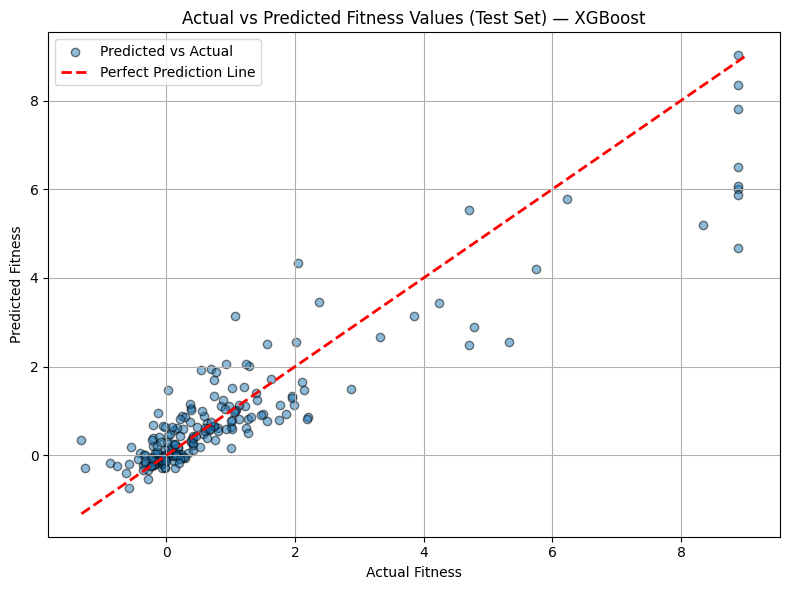


[INFO] Starting bootstrapping for performance metrics on test set...


KeyboardInterrupt: 

In [21]:
if __name__ == "__main__":
    main()
